In [4]:


#!/usr/bin/env python
# coding: utf-8

import sys  # to put the SCM into the PYTHONPATH

sys.path.append('../../library/F2PY')


###########################################
# Imports
###########################################
from sys import exit
import time as TIME
import xarray as xr
from scipy.interpolate import interp1d
import scipy.signal
from scm_class import SCM
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from unit_tests import is_in_range

###################################################
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.facecolor': 'white'})
plt.rcParams.update({'savefig.facecolor': 'white'})
###########################################


# colors
blue, orange, magenta, grey, green = '#0db4c3', '#eea021', '#ff0364', '#606172', '#3fb532'

# ===========================================================================
case = 'FC500'


saving_path = '../figures/'
saving_name = case+'72h_profile_LES_vs_EDMF.png'


# loading LES output once before using the function

file = 'GN_01.1.OC_01.000_copy.nc'


path = '../data/'+case+'/'
les = xr.open_dataset(path+file)
LG_MEAN = xr.open_dataset(
    path+file, group='/LES_budgets/Mean/Cartesian/Not_time_averaged/Not_normalized/cart')
TH_les = (LG_MEAN.MEAN_TH - 273.15).data
U_les = (LG_MEAN.MEAN_U).data
V_les = (LG_MEAN.MEAN_V).data

LG_RES = xr.open_dataset(
    path+file, group='/LES_budgets/Resolved/Cartesian/Not_time_averaged/Not_normalized/cart')
LG_SBG = xr.open_dataset(
    path+file, group='/LES_budgets/Subgrid/Cartesian/Not_time_averaged/Not_normalized/cart')
WTH = (LG_RES.RES_WTH + LG_SBG.SBG_WTHL).data
WU = (LG_RES.RES_WU + LG_SBG.SBG_WU).data
WV = (LG_RES.RES_WV + LG_SBG.SBG_WV).data
corr_tke_les = 0. #-2e-04+1.0e-08
TKE = (LG_RES.RES_KE + LG_SBG.SBG_TKE).data + corr_tke_les
WTKE = (LG_RES.RES_WKE + LG_SBG.SBG_WTKE).data

time_les = les.time_les

# plt.plot(WTKE[-1], z_r_les)
# plt.plot(WTKE[-1]-WPHI_over_RHO_0[-1], z_r_les, 'ko')
# plt.show()

# numpy array of integer hours, starting at inital time + 1h
time = ((time_les - time_les[0]) / np.timedelta64(1, 'h')).data.astype(int) + 1

# remap level_les on negative depth values
z_r_les = (les.level_les - (les.level_les[0] + les.level_les[-1])).data
instant=-1
mld = (-z_r_les[(-WTH[instant]).argmax()])

# ===========================================================================

# Define the common parameters:
common_params = {
    'nz': 100,
    'dt': 50.,
    'h0': 2000.,
    'thetas': 6.5,
    'hc': 400,
    'nbhours': 72,
    'outfreq': 1,
    'output_filename': "scm_output.nc",
    'T0': 2.,
    'N0': 1.9620001275490499e-6,
    'Tcoef': 0.2048,
    'SaltCst': 35.,
    'lat0': 0.,
    'sustr': 0.,
    'svstr': 0.,
    'stflx': -500.,
    'srflx': 0.,
    'ssflx': 0.,
    'eddy_diff': True,
    'evd': False,
    'mass_flux_tra': True,
    'mass_flux_dyn': True,
    'mass_flux_tke': True,
    'mass_flux_tke_trplCorr': True,
    'mass_flux_small_ap': False,
    'lin_eos': True,
    'extrap_ak_surf': True,
    'tke_sfc_dirichlet': False,
    'eddy_diff_tke_const': 'NEMO',
    'entr_scheme': 'R10',
    'Cent': 0.99,
    'Cdet': 1.99,       # 'Cdet': 2.5,
    'wp_a': 1.3,
    'wp_b': 1.3,      # 'wp_b': 1.
    'wp_bp': 0.003*250,     #      0.002,
    'up_c': 0.5,
    'vp_c': 0.5,
    'bc_ap': 0.2,    #0.3,
    'delta_bkg': 0.006*250,   # 0.006,
    'wp0' : -0.5e-08,
    'output_filename': 'run',
    'write_netcdf': True
}



# Define parameters specific to each run (overwrite common parameters):

run_label = ['ED+EVD', 'EDMF-Energy']
runs = [
    {
        'eddy_diff': True,
        'evd': True,
        'mass_flux_tra': False,
        'mass_flux_dyn': False,
        'mass_flux_tke': False,
        'mass_flux_tke_trplCorr': False,
        'output_filename': 'run1.nc'

    },
    {
        'eddy_diff': True,
        'evd': False,
        'mass_flux_tra': True,
        'mass_flux_dyn': True,
        'mass_flux_tke': True,
        'mass_flux_tke_trplCorr': True,
        'output_filename': 'FC500_edmf_ocean.nc'
    }
        ]




scm = [0]*len(runs)

# Run the SCM
for i, run_params in enumerate(runs):
    params = common_params.copy()  # Create a copy of common_params
    params.update(run_params)  # Update with run_params
    scm[i] = SCM(**params)
    scm[i].run_direct()

    # test zinv
    if scm[i].MF_tra or scm[i].MF_dyn: 
        print(run_label[i])
        reference=-320
        #reference=-mld #LES value
        is_in_range(value=scm[i].zinv, value_name='zinv', reference=reference,tolerance=10 )

# LOAD outputs

# TH_scm = [0]*len(runs)
# U_scm = [0]*len(runs)
# V_scm = [0]*len(runs)

# #interpolate scm output on LES #TODO do the converse to reduce computation cost?


# for i, run_params in enumerate(runs):
#     TH_scm = scm[i].t_history
#     U_scm  = scm[i].u_history
#     V_scm  = scm[i].v_history

instant = 71


mld = (-z_r_les[(-WTH[instant]).argmax()]).data






EDMF-Energy
Test sucessfully passed zinv is -320.7210965074032 , and the reference value is -320 +- 10



In [5]:
ds = {}

ds['ket'] = xr.open_dataset(path+'FCcompManolis_ket.nc')
ds['keps'] = xr.open_dataset(path+'FCcompManolis_kepsilon.nc')
ds['edmf_ocean'] = xr.open_dataset('FC500_edmf_ocean.nc')



In [14]:
ds['edmf_ocean']

<xarray.Dataset>
Dimensions:     (time: 73, z_w: 101, z_r: 100)
Coordinates:
  * z_w         (z_w) float64 -2e+03 -1.891e+03 -1.79e+03 ... -6.709 -3.344 0.0
  * z_r         (z_r) float64 -1.945e+03 -1.84e+03 -1.741e+03 ... -5.024 -1.669
Dimensions without coordinates: time
Data variables: (12/47)
    ocean_time  (time) timedelta64[ns] ...
    taux        (time) float64 ...
    tauy        (time) float64 ...
    Qns         (time) float64 ...
    Qs          (time) float64 ...
    Fw          (time) float64 ...
    ...          ...
    u_p         (time, z_w) float64 ...
    v_p         (time, z_w) float64 ...
    buoyMF      (time, z_w) float64 ...
    shearMF     (time, z_w) float64 ...
    we          (time, z_w) float64 ...
    tke_p       (time, z_w) float64 ...
Attributes: (12/17)
    fcorSIN:                 0.0
    fcorCOS:                 0.00014584232
    eddy_diff:               True
    evd:                     False
    mass_flux_tra:           True
    mass_flux_dyn:           True
    ...                      ...
    T0:                      2.0
    S0:                      35.0
    tkemin:                  1e-06
    akvmin:                  0.0001
    aktmin:                  1e-05
    mxlmin:                  1.0

In [4]:
ds['keps']

<xarray.Dataset>
Dimensions:    (z_r: 100, t: 72, z_w: 101)
Coordinates:
  * z_w        (z_w) float64 -2e+03 -1.895e+03 -1.797e+03 ... -8.627 -4.313 0.0
  * z_r        (z_r) float64 -1.947e+03 -1.845e+03 -1.75e+03 ... -6.47 -2.156
  * t          (t) float64 50.0 3.65e+03 7.25e+03 ... 2.52e+05 2.556e+05
Data variables: (12/17)
    T          (z_r, t) float64 ...
    S          (z_r, t) float64 ...
    rho        (z_r, t) float64 ...
    U          (z_r, t) float64 ...
    varT       (z_w, t) float64 ...
    eps        (z_w, t) float64 ...
    ...         ...
    Kt         (z_w, t) float64 ...
    Km         (z_w, t) float64 ...
    cmu        (z_w, t) float64 ...
    cmu_prime  (z_w, t) float64 ...
    alpha_n    (z_w, t) float64 ...
    alpha_m    (z_w, t) float64 ...

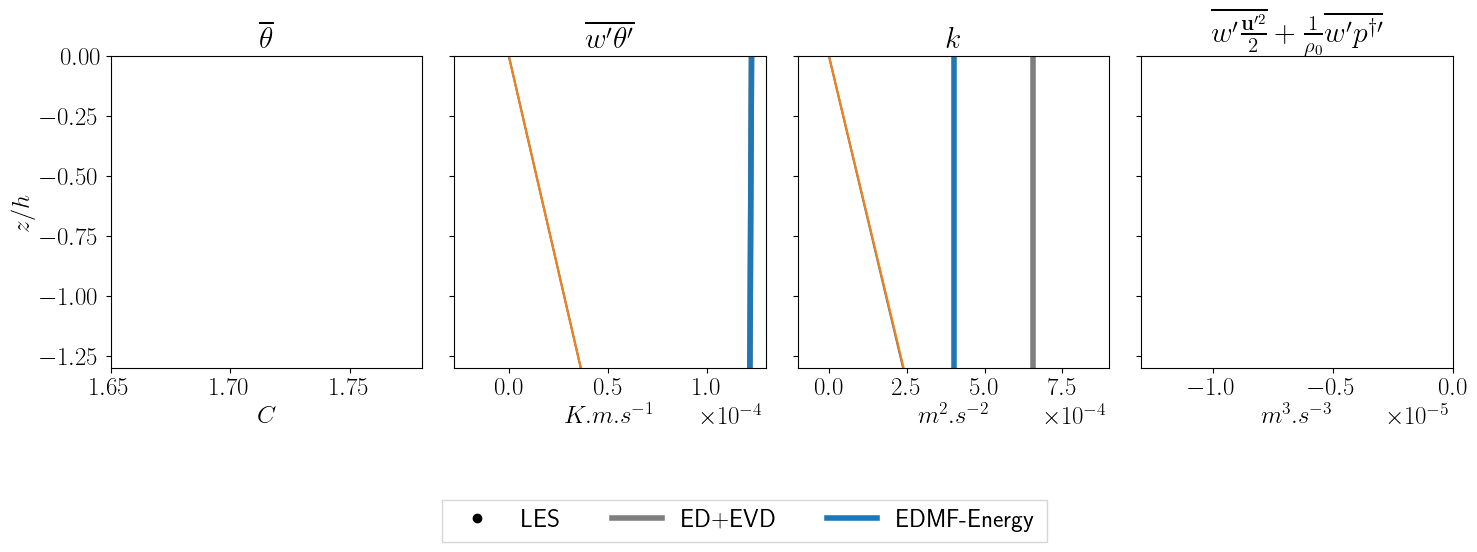

In [15]:



################################# PLOTTING
styles = ['-', '-', '-']
#colors = ['k',blue,orange]
colors = ['k','tab:blue','tab:orange']
alpha = [0.5,1,1]
linewidth = [4]*(len(run_label))

style_les = 'ko'
alpha_les = 1
linewidth_les = 4





###########################################################################################
#============================================ FC ==========================================
###########################################################################################

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False,
                        sharey=True, figsize=(15, 5))

# ===============================================================
ax = axes.flat[0]
ax.set_xlabel(r'$ C$')
ax.set_ylabel(r'$z / h $')
ax.set_title(r'$\overline{\theta}$')


ax.plot(TH_les[instant], z_r_les/mld, style_les,
        alpha=alpha_les, linewidth=linewidth_les,  label='LES')

for i, label in enumerate(run_label):
    ax.plot(scm[i].t_np1[:, 0], scm[i].z_r/mld, linestyle=styles[i], color = colors[i],
            alpha=alpha[i], linewidth=linewidth[i], label=label)

ax.plot(ds['keps']['T'][:,instant], ds['keps']['z_r']/mld, label='keps')
ax.plot(ds['ket']['T'][:,instant], ds['keps']['z_r']/mld, label='ket')


ax.set_xlim((1.65, 1.78))
ax.set_ylim((-1.3, 0))

# ===============================================================


ax = axes.flat[1]
ax.set_title(r'$\overline{w^\prime \theta^\prime}$')

ax.plot(WTH[instant], z_r_les/mld, style_les,
        alpha=alpha_les, linewidth=linewidth_les, label='LES')

for i, label in enumerate(run_label):
    if run_label == 'ED':
        ax.plot(-(scm[i].wted), scm[i].z_w/mld, linestyle=styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)
    else:
        ax.plot(-(scm[i].wted + scm[i].wtmf), scm[i].z_w/mld, linestyle=styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)
        
# ax.plot( -scm[1].wted, scm[1].z_w/mld, color ='tab:blue'  , linestyle ='--', alpha=1.0 , linewidth=3 )
# ax.plot( -scm[2].wted, scm[2].z_w/mld, color ='tab:orange', linestyle ='--', alpha=1.0 , linewidth=3 )

ax.plot(ds['keps']['wT'][:,-1], ds['keps']['z_w']/mld, label='keps')
ax.plot(ds['ket']['wT'][:,-1], ds['keps']['z_w']/mld, label='ket')


ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

#ax.plot( -out[1]['WT_ED'][-1,:], out[1].z_w/mld, color ='tab:blue'  , linestyle ='--', alpha=1.0 , linewidth=3 )
#ax.plot( -out[2]['WT_ED'][-1,:], out[2].z_w/mld, color ='tab:orange', linestyle ='--', alpha=1.0 , linewidth=3 )

ax.set_ylim((-1.3, 0))

ax.set_xlabel(r'$K.m.s^{-1}$')


# ===============================================================
# ===============================================================
ax = axes.flat[2]
ax.set_title(r'$k$')

ax.plot(TKE[instant], z_r_les/mld, style_les,
        alpha=alpha_les, linewidth=linewidth_les, label='LES')

for i, label in enumerate(run_label):
    ax.plot(scm[i].tke_np1, scm[i].z_w/mld, linestyle=styles[i], color = colors[i],
            alpha=alpha[i], linewidth=linewidth[i], label=label)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

ax.plot(ds['keps']['TKE'][:,-1], ds['keps']['z_w']/mld, label='keps')
ax.plot(ds['ket']['TKE'][:,-1], ds['keps']['z_w']/mld, label='ket')

ax.set_xlim((-0.0001, 0.0009))
ax.set_ylim((-1.3, 0))

ax.set_xlabel(r'$m^2.s^{-2}$')



# ===============================================================
ax = axes.flat[3]
ax.set_title(r'$\overline{w^\prime \frac{\mathbf{u}^{\prime 2}}{2}  } + \frac{1}{\rho_0} \overline{w^\prime p^{\dagger \prime} }$')

#add velocity-pressure correlation
cond_samp = xr.open_dataset(path+    'FC500_object_diags_Cw_m1_72h.nc')  

ax.plot(WTKE[instant]-cond_samp['TOT_intra_WPHI_over_RHO_0'][-1], z_r_les/mld, style_les,
        alpha=alpha_les, linewidth=linewidth_les, label='LES')


for i, label in enumerate(run_label):
    ax.plot((scm[i].wtke), scm[i].z_r/mld, linestyle=styles[i], color = colors[i],
            alpha=alpha[i], linewidth=linewidth[i], label=label)


ax.set_xlim((- 1.3e-5, 0))
ax.set_ylim((-1.3, 0))

ax.set_xlabel(r'$m^3.s^{-3}$')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(
    0.5, -0.05), fancybox=False, shadow=False, ncol=4)

for ax in axes.flat:
    ax.set_box_aspect(1)



fig.tight_layout()

# ===============================================================






# plt.savefig(saving_path+saving_name, bbox_inches='tight', dpi=300)


# print('figure saved at'+saving_path+saving_name)

#plt.show()

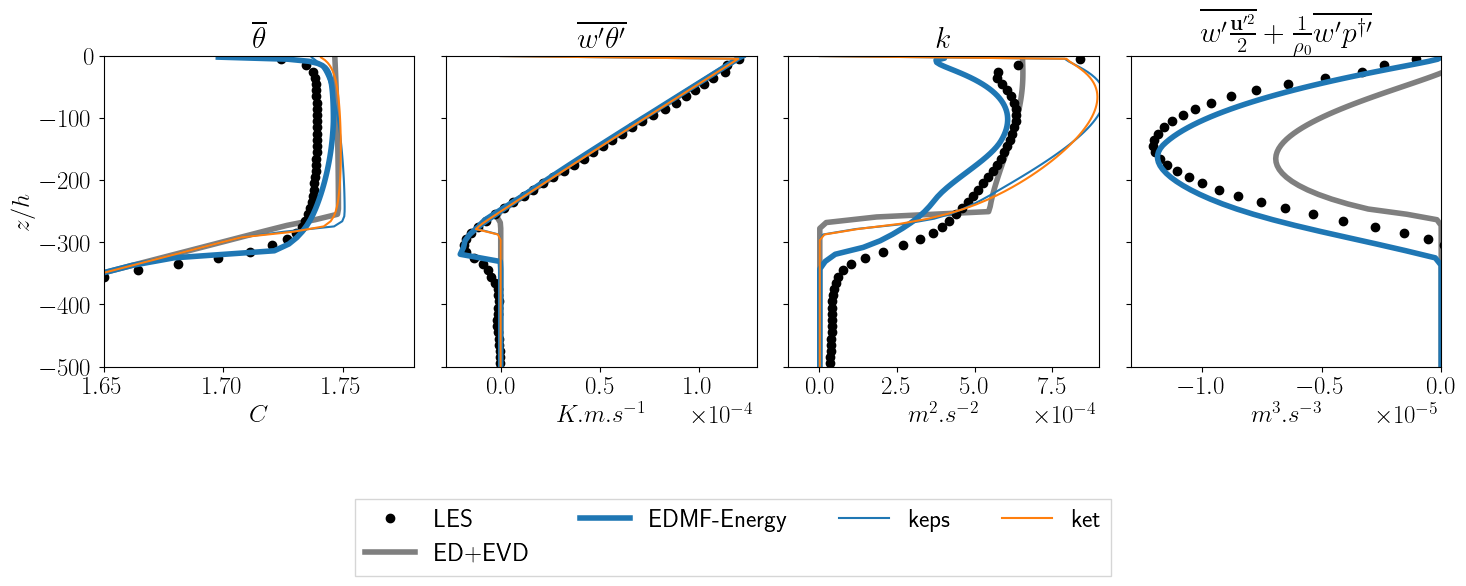

In [9]:



################################# PLOTTING
styles = ['-', '-', '-']
#colors = ['k',blue,orange]
colors = ['k','tab:blue','tab:orange']
alpha = [0.5,1,1]
linewidth = [4]*(len(run_label))

style_les = 'ko'
alpha_les = 1
linewidth_les = 4


mld=1


###########################################################################################
#============================================ FC ==========================================
###########################################################################################

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False,
                        sharey=True, figsize=(15, 5))

# ===============================================================
ax = axes.flat[0]
ax.set_xlabel(r'$ C$')
ax.set_ylabel(r'$z / h $')
ax.set_title(r'$\overline{\theta}$')


ax.plot(TH_les[instant], z_r_les/mld, style_les,
        alpha=alpha_les, linewidth=linewidth_les,  label='LES')

for i, label in enumerate(run_label):
    ax.plot(scm[i].t_np1[:, 0], scm[i].z_r/mld, linestyle=styles[i], color = colors[i],
            alpha=alpha[i], linewidth=linewidth[i], label=label)

ax.plot(ds['keps']['T'][:,instant], ds['keps']['z_r']/mld, label='keps')
ax.plot(ds['ket']['T'][:,instant], ds['keps']['z_r']/mld, label='ket')


ax.set_xlim((1.65, 1.78))
ax.set_ylim((-500, 0))

# ===============================================================


ax = axes.flat[1]
ax.set_title(r'$\overline{w^\prime \theta^\prime}$')

ax.plot(WTH[instant], z_r_les/mld, style_les,
        alpha=alpha_les, linewidth=linewidth_les, label='LES')

for i, label in enumerate(run_label):
    if run_label == 'ED':
        ax.plot(-(scm[i].wted), scm[i].z_w/mld, linestyle=styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)
    else:
        ax.plot(-(scm[i].wted + scm[i].wtmf), scm[i].z_w/mld, linestyle=styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)
        
# ax.plot( -scm[1].wted, scm[1].z_w/mld, color ='tab:blue'  , linestyle ='--', alpha=1.0 , linewidth=3 )
# ax.plot( -scm[2].wted, scm[2].z_w/mld, color ='tab:orange', linestyle ='--', alpha=1.0 , linewidth=3 )

ax.plot(ds['keps']['wT'][:,-1], ds['keps']['z_w']/mld, label='keps')
ax.plot(ds['ket']['wT'][:,-1], ds['keps']['z_w']/mld, label='ket')


ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

#ax.plot( -out[1]['WT_ED'][-1,:], out[1].z_w/mld, color ='tab:blue'  , linestyle ='--', alpha=1.0 , linewidth=3 )
#ax.plot( -out[2]['WT_ED'][-1,:], out[2].z_w/mld, color ='tab:orange', linestyle ='--', alpha=1.0 , linewidth=3 )

ax.set_ylim((-500, 0))

ax.set_xlabel(r'$K.m.s^{-1}$')


# ===============================================================
# ===============================================================
ax = axes.flat[2]
ax.set_title(r'$k$')

ax.plot(TKE[instant], z_r_les/mld, style_les,
        alpha=alpha_les, linewidth=linewidth_les, label='LES')

for i, label in enumerate(run_label):
    ax.plot(scm[i].tke_np1, scm[i].z_w/mld, linestyle=styles[i], color = colors[i],
            alpha=alpha[i], linewidth=linewidth[i], label=label)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

ax.plot(ds['keps']['TKE'][:,-1], ds['keps']['z_w']/mld, label='keps')
ax.plot(ds['ket']['TKE'][:,-1], ds['keps']['z_w']/mld, label='ket')

ax.set_xlim((-0.0001, 0.0009))
ax.set_ylim((-500, 0))

ax.set_xlabel(r'$m^2.s^{-2}$')



# ===============================================================
ax = axes.flat[3]
ax.set_title(r'$\overline{w^\prime \frac{\mathbf{u}^{\prime 2}}{2}  } + \frac{1}{\rho_0} \overline{w^\prime p^{\dagger \prime} }$')

#add velocity-pressure correlation
cond_samp = xr.open_dataset(path+    'FC500_object_diags_Cw_m1_72h.nc')  

ax.plot(WTKE[instant]-cond_samp['TOT_intra_WPHI_over_RHO_0'][-1], z_r_les/mld, style_les,
        alpha=alpha_les, linewidth=linewidth_les, label='LES')


for i, label in enumerate(run_label):
    ax.plot((scm[i].wtke), scm[i].z_r/mld, linestyle=styles[i], color = colors[i],
            alpha=alpha[i], linewidth=linewidth[i], label=label)


ax.set_xlim((- 1.3e-5, 0))
ax.set_ylim((-500, 0))

ax.set_xlabel(r'$m^3.s^{-3}$')

handles, labels = axes.flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(
    0.5, -0.05), fancybox=False, shadow=False, ncol=4)

for ax in axes.flat:
    ax.set_box_aspect(1)



fig.tight_layout()

# ===============================================================






# plt.savefig(saving_path+saving_name, bbox_inches='tight', dpi=300)


# print('figure saved at'+saving_path+saving_name)

#plt.show()